In [1]:
import sys
import os
import pickle
import random
import numpy as np
from skimage.segmentation import felzenszwalb
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

sys.path.append('../')

In [9]:
with open('orange_histograms.pickle', 'rb') as handle:
    pos = pickle.load(handle)
with open('pos_histograms_720p.pickle', 'rb') as handle:
    pos1 = pickle.load(handle)
with open('neg_histograms.pickle', 'rb') as handle:
    neg = pickle.load(handle)
    
pos = pos + pos1
len(pos)

10619

In [10]:
np.random.seed(42)
random.seed(42)

random_neg = random.sample(neg, 10619)

In [11]:
def evaluate_model(model, X_train, y_train, cv):
    # Compute cross-validation scores
    scores = cross_val_score(model, X_train, y_train, cv=cv)
    accuracy = scores.mean()
    
    # Compute cross-validation predicted values
    y_pred = cross_val_predict(model, X_train, y_train, cv=cv)
    
    # Compute precision, recall, and F1-score
    precision = precision_score(y_train, y_pred, average='weighted')
    recall = recall_score(y_train, y_pred, average='weighted')
    f1 = f1_score(y_train, y_pred, average='weighted')
    
    # Print evaluation metrics
    print("Cross-validation scores: {}".format(scores))
    print("Mean accuracy: {:.4f}".format(accuracy))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-score: {:.4f}".format(f1))


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score


X_train = np.array(pos + random_neg)
y_train = np.concatenate((np.ones(len(pos)), -np.ones(len(random_neg))))

clf = RandomForestClassifier(max_depth=100)

evaluate_model(clf, X_train, y_train, 10)

clf.fit(X_train, y_train)



Cross-validation scores: [0.96045198 0.99105461 0.93644068 0.99764595 0.99482109 0.99482109
 0.99764595 0.98822976 0.99670278 0.99340556]
Mean accuracy: 0.9851
Precision: 0.9853
Recall: 0.9852
F1-score: 0.9852


RandomForestClassifier(max_depth=100)

In [13]:
with open('orange_segment_classifier.pickle', 'wb') as handle:
    pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Apply to images

In [14]:
from src.auto_labeling.segmentation import *

In [15]:
with open('orange_segment_classifier.pickle', 'rb') as handle:
    clf = pickle.load(handle)

In [16]:
source_path = "../data/datasets/roadfollower/test/apex/"
source = os.listdir(source_path)
i = 1

In [17]:
def apex_from_segments(segments):
    height, width = segments.shape

    # Calculate the middle row index
    middle_row = height // 2

   # Initialize variables to track the indices of -1 values
    first_neg_one_idx = None
    last_neg_one_idx = None

    # Iterate over the rows from the middle row to the bottom row
    for y in range(middle_row, height):
        row = segments[y, :]
        # Check if there are any -1 values in the row
        if -1 in row:
            # If this is the first row with -1 values, record the indices and the line index
            if first_neg_one_idx is None:
                first_neg_one_idx = np.where(row == -1)[0][0]
                last_neg_one_idx = np.where(row == -1)[0][-1]
                line_idx = y
                center_idx = (first_neg_one_idx + last_neg_one_idx) // 2
                return (line_idx, center_idx)
            
    for y in range(0, middle_row):
        row = segments[y, :]
        # Check if there are any -1 values in the row
        if -1 in row:
            # If this is the first row with -1 values, record the indices and the line index
            if first_neg_one_idx is None:
                first_neg_one_idx = np.where(row == -1)[0][0]
                last_neg_one_idx = np.where(row == -1)[0][-1]
                line_idx = y
                center_idx = (first_neg_one_idx + last_neg_one_idx) // 2
                return (line_idx, center_idx)

    return -1

In [18]:
def auto_label_img(img_path, clf):
    img = plt.imread(os.path.join(source_path, source[i]))
    segments = felzenszwalb(img, scale=20, sigma=1, min_size=50)

    for seg_idx in np.unique(segments):
        hist = get_segment_histogram(img, segments, seg_idx) 
        y_pred = clf.predict(np.array(hist).reshape(1,-1))
        if y_pred == 1:
            segments[segments == seg_idx] = -1
            
    prediction = apex_from_segments(segments)
    
    if prediction == -1:
        print("Could not auto-label passed image")
    else:
        return prediction

In [19]:
i += 1
auto_label_img(os.path.join(source_path, source[0]), clf)

(134, 7)

/home/romain/Documents/roadfollower/scripts/notebooks/../src/auto_labeling/segmentation.py:26: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
  rr, cc = draw.circle(y, x, r, shape=mask.shape)


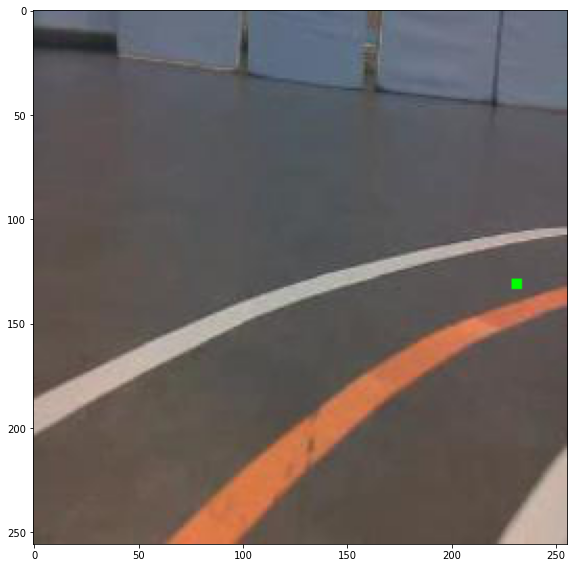

In [37]:
plt.rcParams['figure.figsize'] = (8, 8)
i += 1
img = plt.imread(os.path.join(source_path, source[i]))
segments = felzenszwalb(img, scale=20, sigma=1, min_size=50)

for seg_idx in np.unique(segments):
    hist = get_segment_histogram(img, segments, seg_idx) 
    y_pred = clf.predict(np.array(hist).reshape(1,-1))
    if y_pred == 1:
        segments[segments == seg_idx] = -1
    
preview_lane(img, segments, (0,0))


x,y = apex_from_segments(segments)

plt.imshow(draw_circle(img, y,x))